In [ ]:
import os
import cv2
import base64
import requests
import json
import matplotlib.pyplot as plt
import shutil
import numpy as np
from collections import defaultdict
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


CUTS_PATH = "/home/tyler/python/agents/cuts"
CUTS_DESCRIPTION_PATH = "/home/tyler/python/agents/cut_descriptions"
OLLAMA_URL = "http://localhost:11434/api/generate"
PERCENT_FRAMES_TO_SAMPLE = 0.4

In [ ]:
def describe_image(buffer, model="llava:7b"):
    image_base64 = base64.b64encode(buffer).decode("utf-8")
    payload = {
        "model": model,
        "prompt": "Describe this image which is a frame from a video, include things like the position of objects in the screen and any text if it exists in the image. Only describe text if you're "
        "totally sure about what the text reads. Just describe the image and do not add any explaination or assumptions about what is happening.",
        "images": [image_base64],
    }
    response = requests.post("http://localhost:11434/api/generate", json=payload)

    full_response = ""
    for line in response.iter_lines():
        if line:
            # print(line.decode("utf-8"))
            data = json.loads(line)
            full_response += data.get("response", "")
    return full_response


def get_frames(cut_path):
    frame_buffers_to_return = []
    print(f"Cut name: {cut_path}")
    cap = cv2.VideoCapture(os.path.join(CUTS_PATH, cut_path))

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames:", total_frames)

    nth_frame_to_sample = int(1 / PERCENT_FRAMES_TO_SAMPLE)

    for frame_num in range(0, total_frames, nth_frame_to_sample):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame {frame_num}")
            continue

        success, buffer = cv2.imencode(".jpg", frame)
        if success:
            print(f"read frame {frame_num}")
            show_frame(frame)
            frame_buffers_to_return.append(buffer)

    cap.release()
    return frame_buffers_to_return


def show_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis("off")  # optional: hides axes
    plt.show()


def write_frame_descriptions(cut, description, frame_index):
    cut = cut.split(".")[0]
    # if os.path.isdir(os.path.join(CUTS_DESCRIPTION_PATH, cut)):
    #     shutil.rmtree(os.path.join(CUTS_DESCRIPTION_PATH, cut))
    print(f"directory to delete : {os.path.join(CUTS_DESCRIPTION_PATH, cut)}")
    os.mkdir(os.path.join(CUTS_DESCRIPTION_PATH, cut))

    file_name = os.path.join(CUTS_DESCRIPTION_PATH, cut, f"{cut}_{frame_index}.txt")
    with open(file_name, "w") as f:
        f.write(description)


def get_activity_per_frame(video_path):
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return []

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"FPS: {fps}, Total Frames: {total_frames}")

    activity_per_frame = []
    prev_frame = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize for faster processing (optional)
        frame = cv2.resize(frame, (320, 240))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_frame is not None:
            # Compute pixel-wise absolute difference
            diff = cv2.absdiff(gray, prev_frame)
            diff_score = np.sum(diff) / diff.size  # Mean change
            activity_per_frame.append(diff_score)

        prev_frame = gray

    cap.release()

    # Normalize to 0-1
    activity_arr = np.array(activity_per_frame)
    if len(activity_arr) == 0:
        print("No frame difference data collected.")
        return []

    normalized = (activity_arr - activity_arr.min()) / (np.ptp(activity_arr) + 1e-5)
    return normalized


def smooth_signal_gaussian(activity, sigma=2):
    return gaussian_filter1d(activity, sigma=sigma)


def adaptive_frame_sampling(activity, min_sample_rate=0.1, max_sample_rate=1.0):
    """
    activity: normalized activity per frame (0 to 1)
    min_sample_rate: lowest sampling rate (e.g. 10% in flat areas)
    max_sample_rate: highest sampling rate (e.g. 100% near peaks)
    Returns: indices of selected frames
    """
    # Scale activity into sampling probability
    sampling_probs = min_sample_rate + activity * (max_sample_rate - min_sample_rate)

    sampled_indices = []
    for i, prob in enumerate(sampling_probs):
        if np.random.rand() < prob:
            sampled_indices.append(i)
    return sampled_indices


def plot_and_save_cut_activity(path, activity, sampled_indices=None):
    plt.figure()
    plt.plot(activity)
    plt.xlabel("Frame number")
    plt.ylabel("Activity (0=still, 1=high change)")
    plt.title("Visual Activity per Second")
    plt.grid(True)

    if sampled_indices is not None:
        for idx in sampled_indices:
            plt.axvline(x=idx, color="red", linestyle="--", alpha=0.6)

        plt.legend(["Activity", "Sampled Frames"])
    plt.savefig(path, dpi=300)


def save_frames_from_video(video_path, frame_list, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for frame_number in frame_list:
        if frame_number >= total_frames or frame_number < 0:
            print(f"Skipping invalid frame number: {frame_number}")
            continue

        # Set the video to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Construct output file path
            filename = os.path.join(output_dir, f"frame_{frame_number}.jpg")
            cv2.imwrite(filename, frame)
            print(f"Saved frame {frame_number} to {filename}")
        else:
            print(f"Failed to read frame {frame_number}")

    cap.release()

In [16]:
nth_frame_to_sample = int(1 / PERCENT_FRAMES_TO_SAMPLE)
nth_frame_to_sample

2

cuts folder path : /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032
sunlight-Scene-032.mp4
FPS: 25, Total Frames: 24
Nuked /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032
Saved frame 0 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_0.jpg
Saved frame 1 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_1.jpg
Saved frame 2 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_2.jpg
Saved frame 4 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_4.jpg
Saved frame 5 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_5.jpg
Saved frame 13 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_13.jpg
Saved frame 15 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_15.jpg
Saved frame 20 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-032/frame_20.jpg
cuts folder path : /home/tyler/python/agents/cut_descriptions/sunlig

/tmp/ipykernel_4274/3027044206.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Nuked /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038
Saved frame 0 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_0.jpg
Saved frame 1 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_1.jpg
Saved frame 14 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_14.jpg
Saved frame 18 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_18.jpg
Saved frame 32 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_32.jpg
Saved frame 35 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_35.jpg
Saved frame 38 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_38.jpg
Saved frame 55 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_55.jpg
Saved frame 56 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_56.jpg
Saved frame 58 to /home/tyler/python/agents/cut_descriptions/sunlight-Scene-038/frame_58.jpg
Saved 

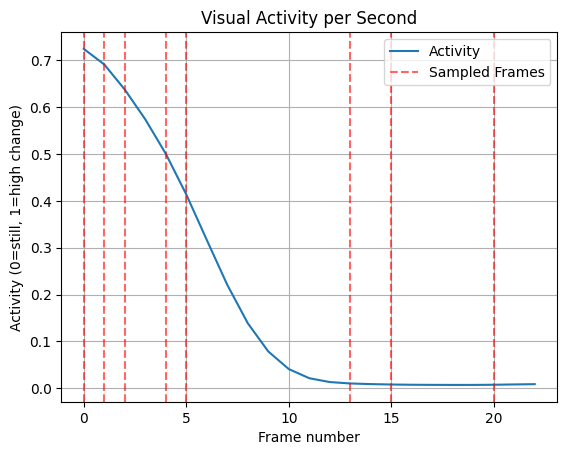

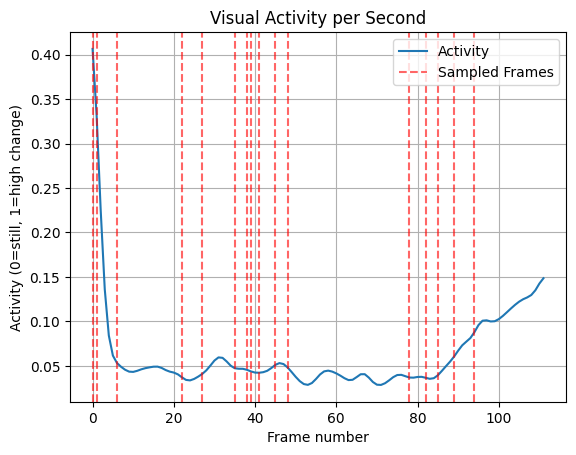

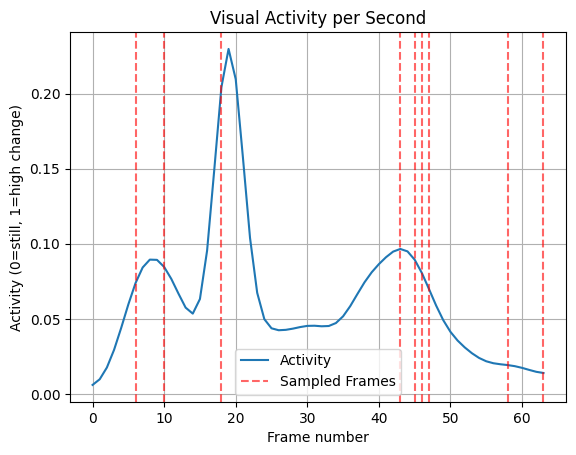

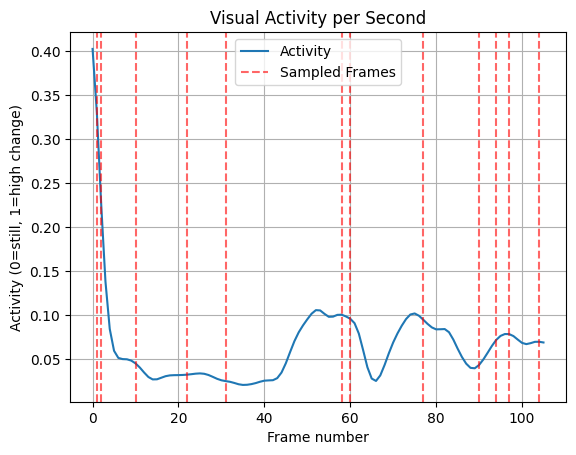

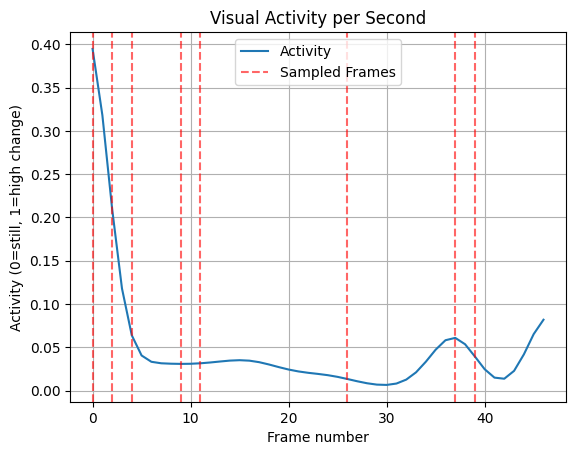

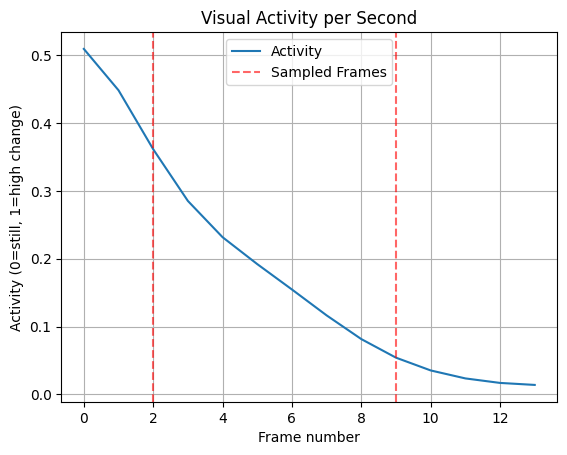

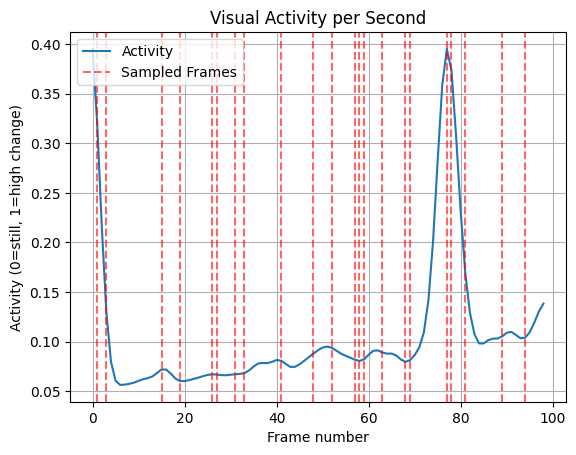

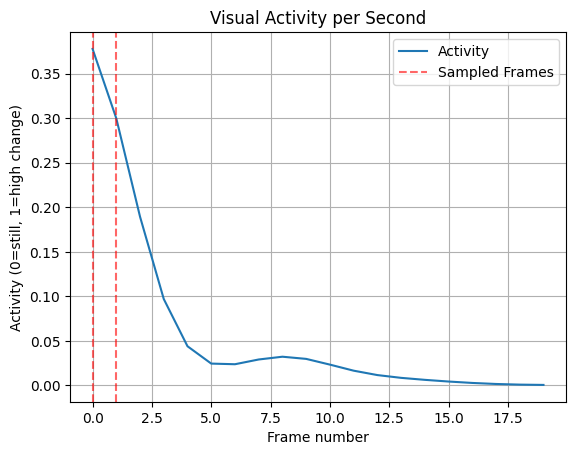

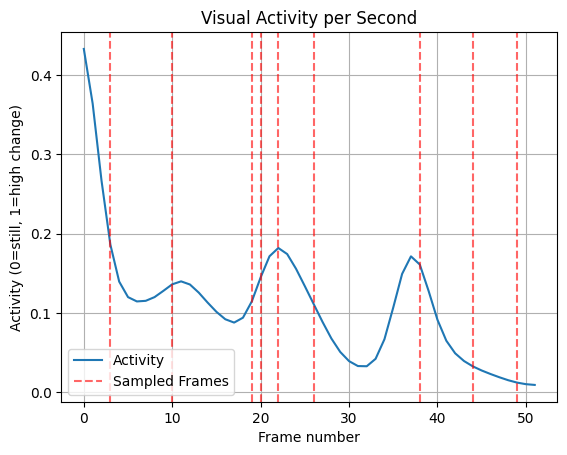

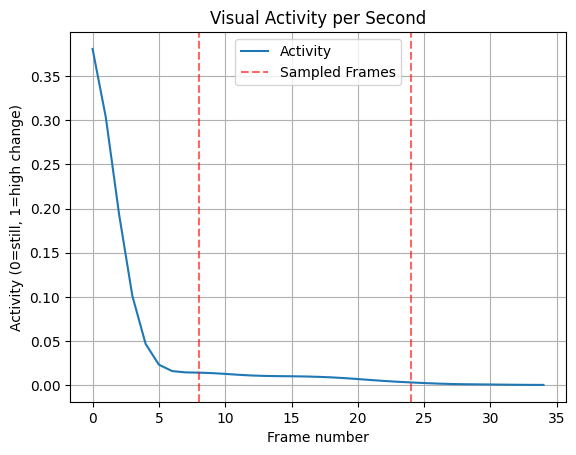

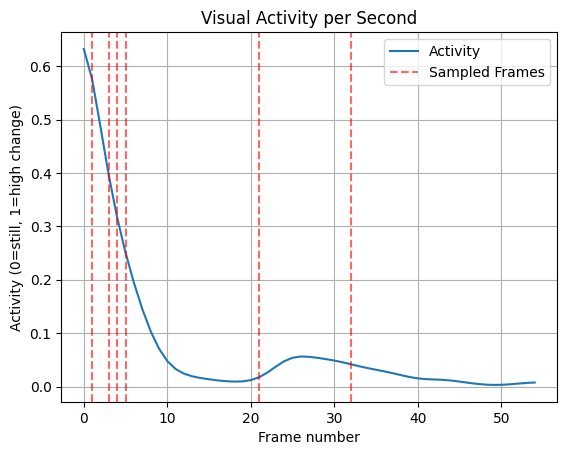

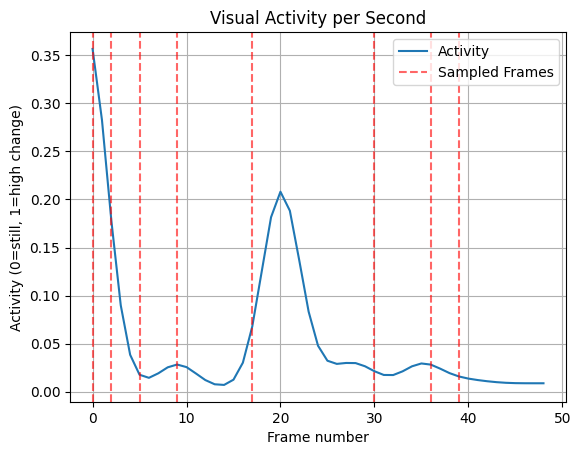

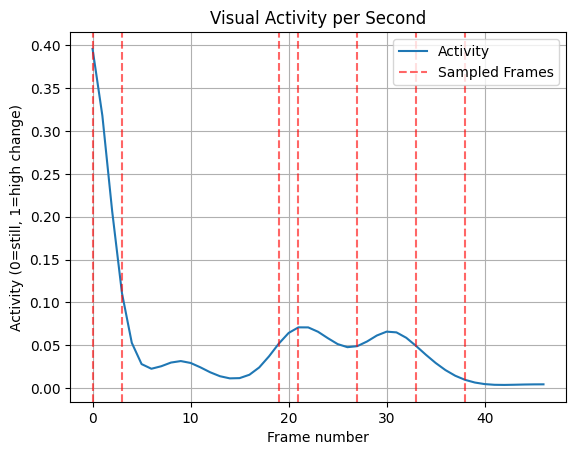

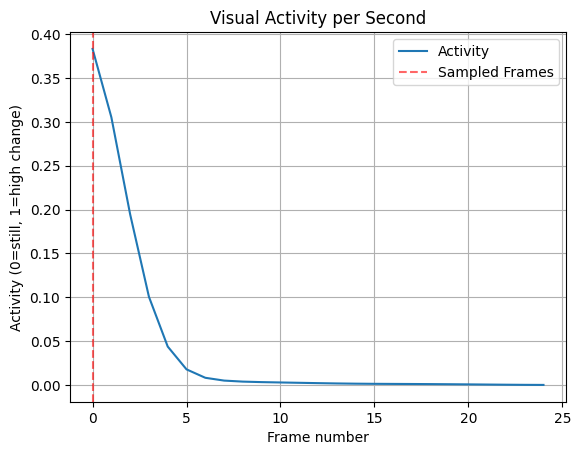

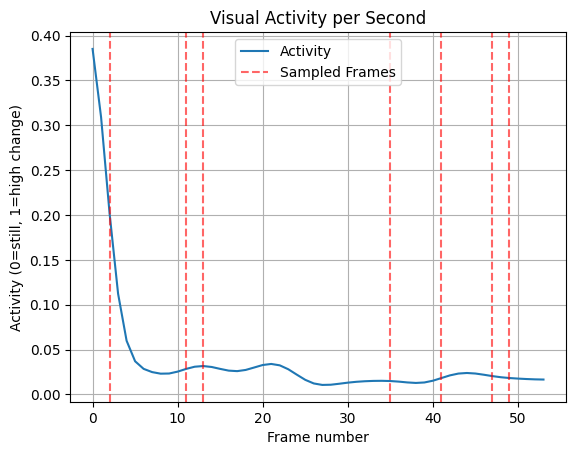

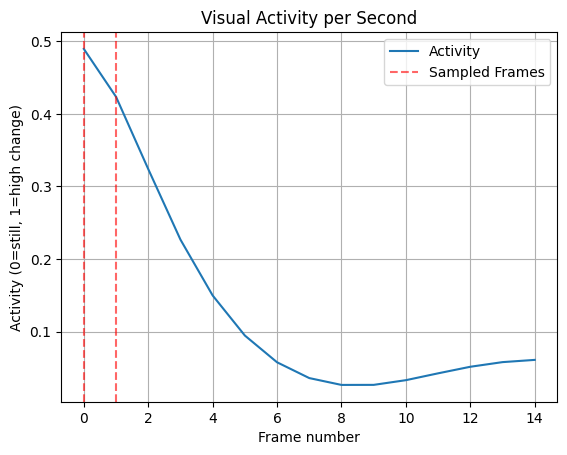

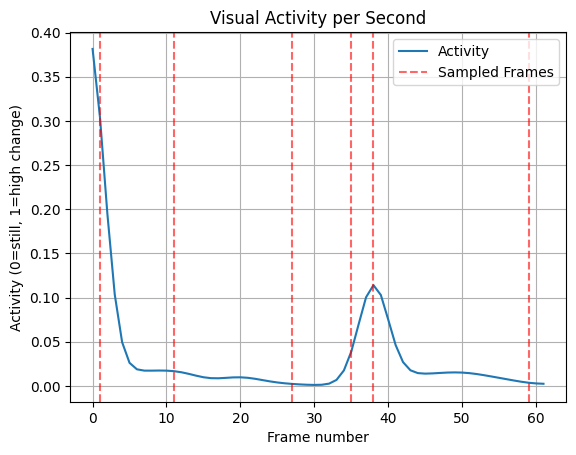

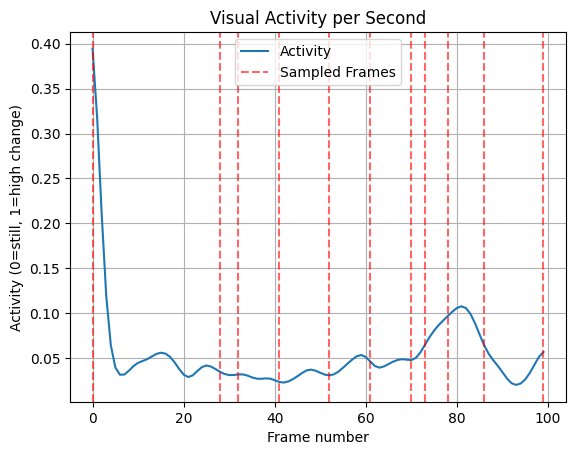

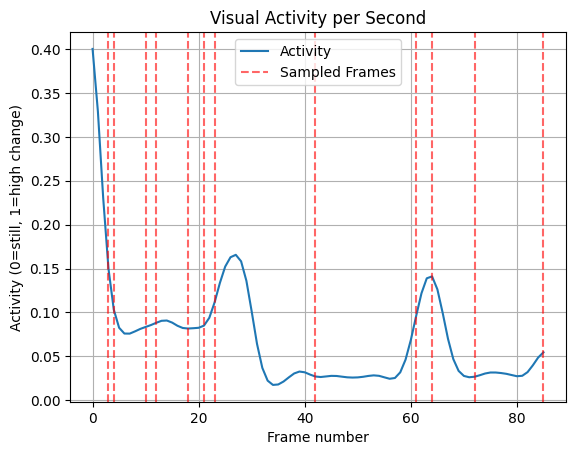

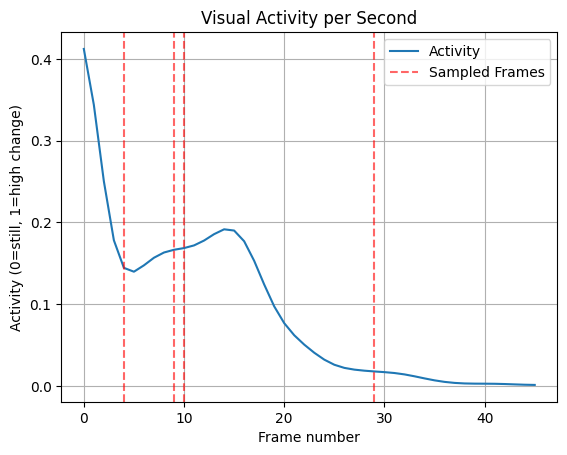

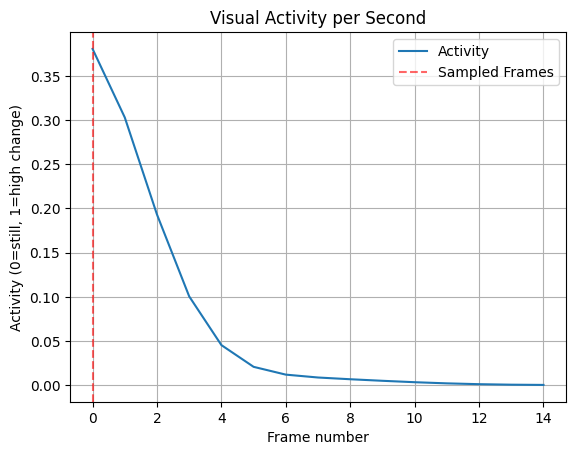

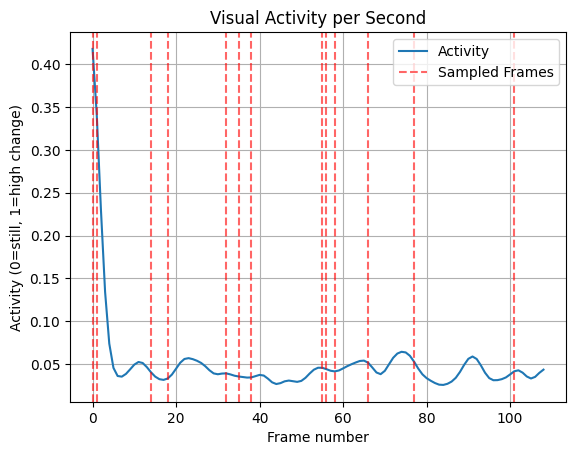

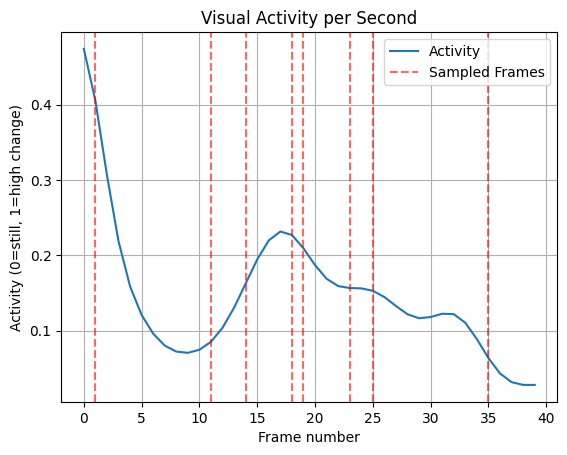

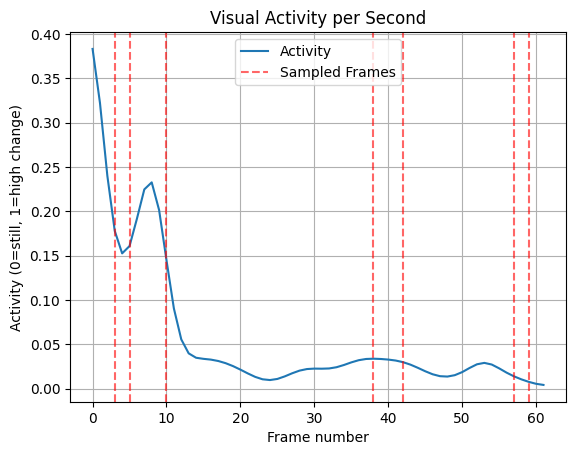

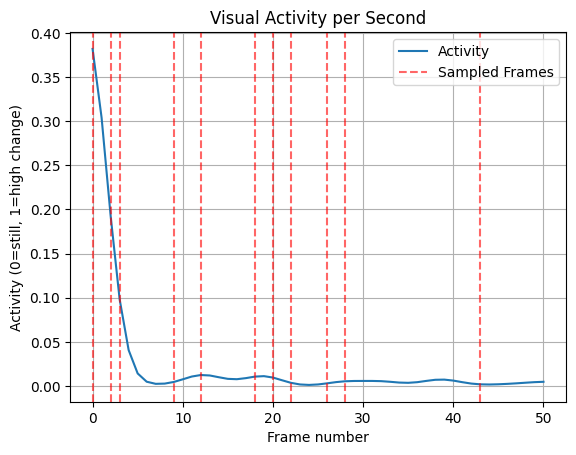

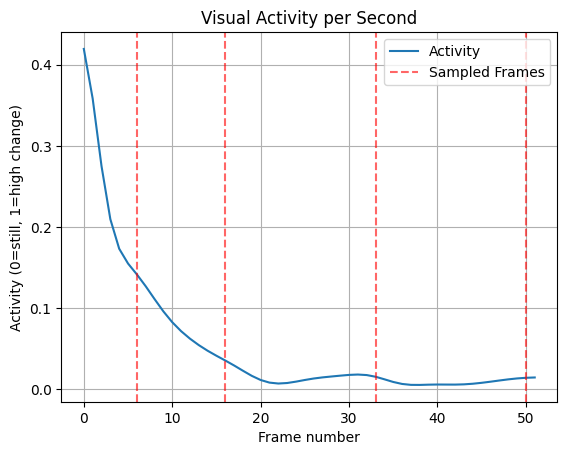

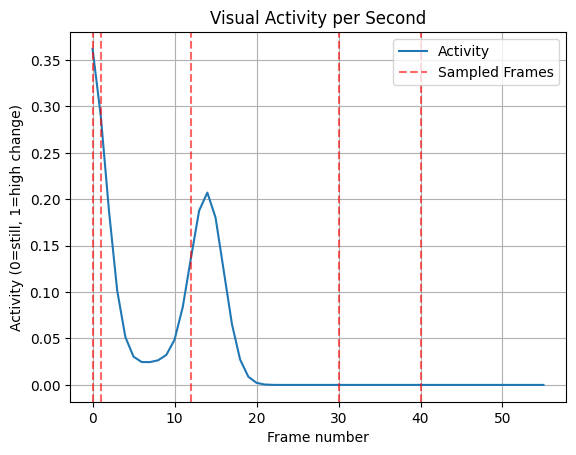

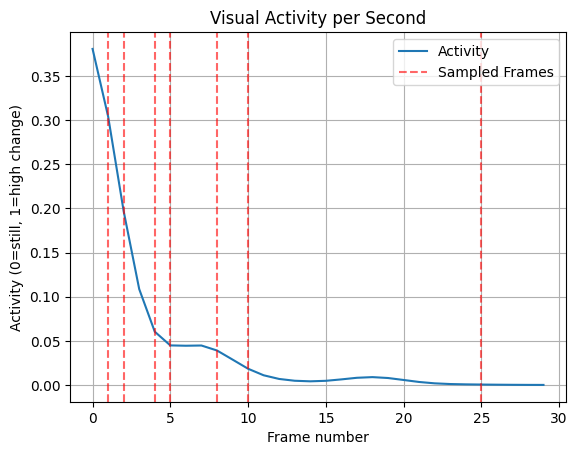

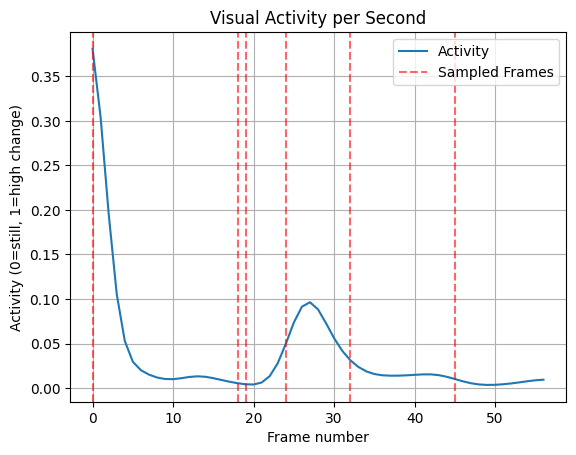

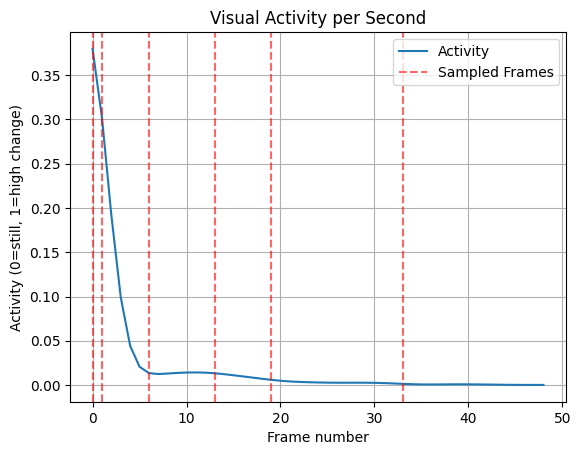

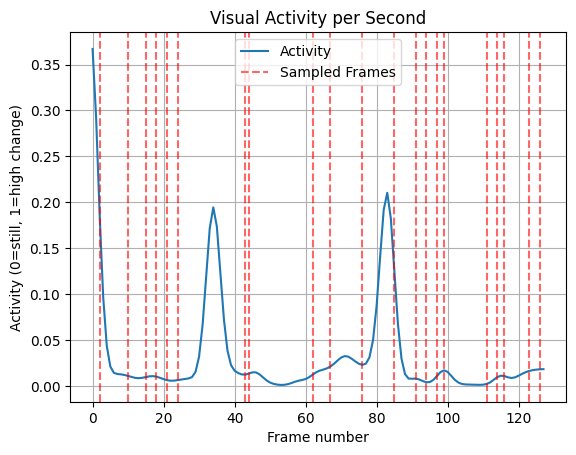

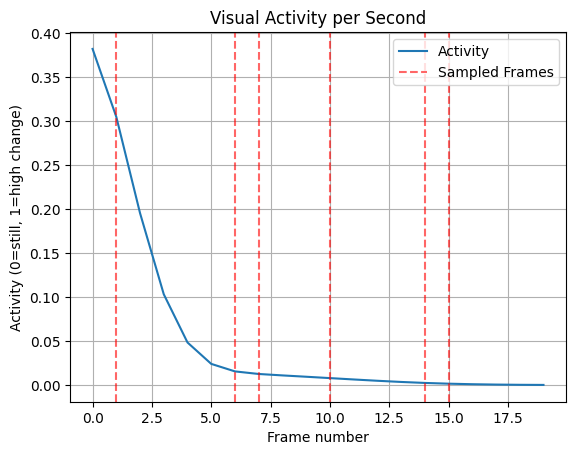

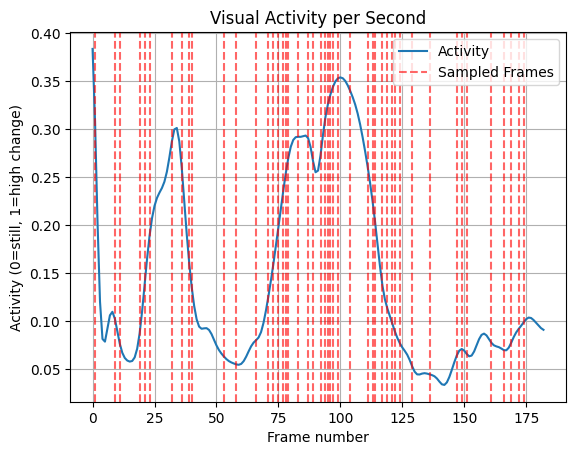

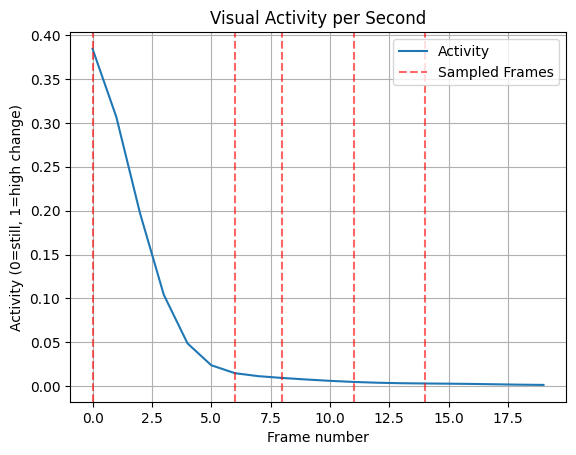

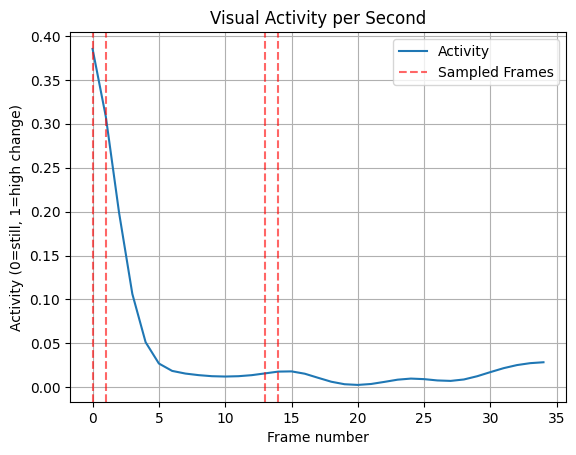

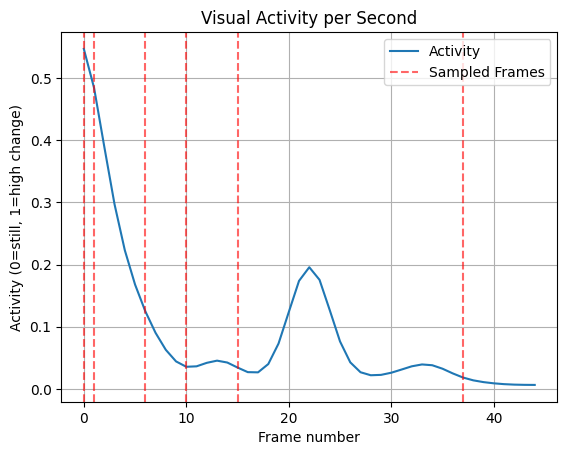

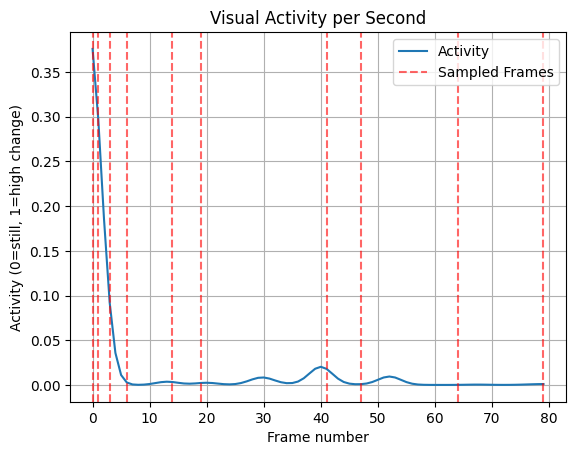

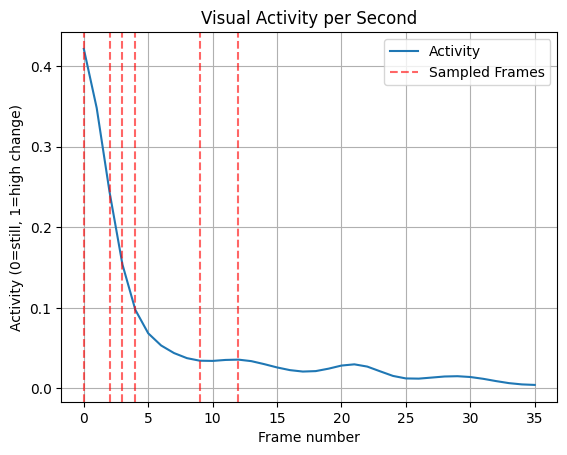

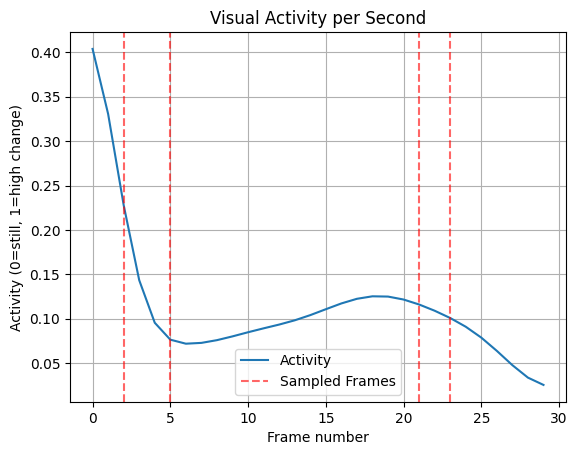

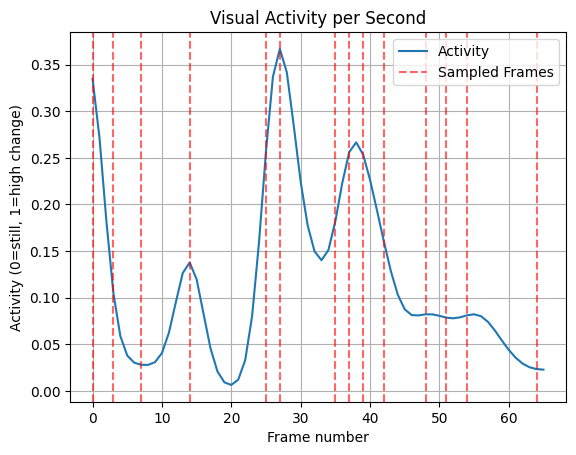

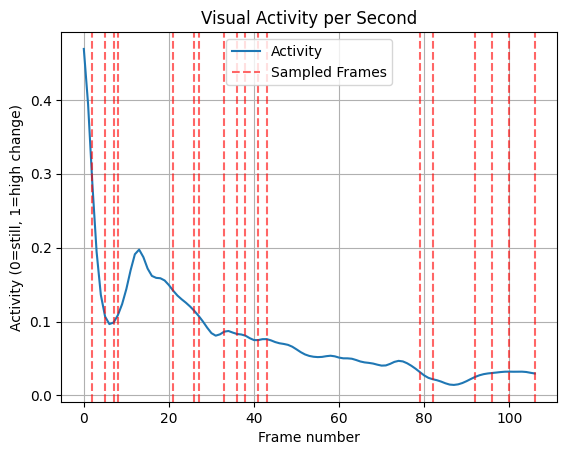

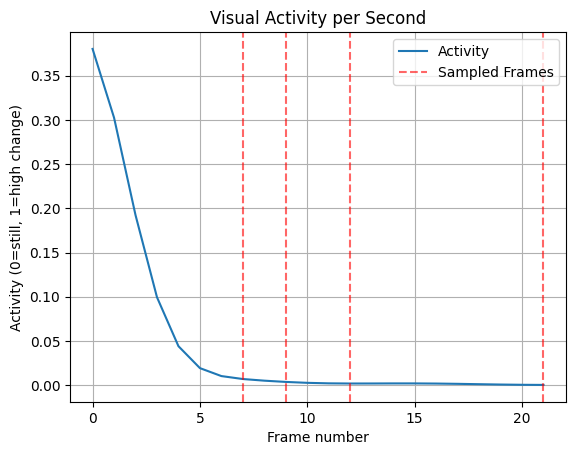

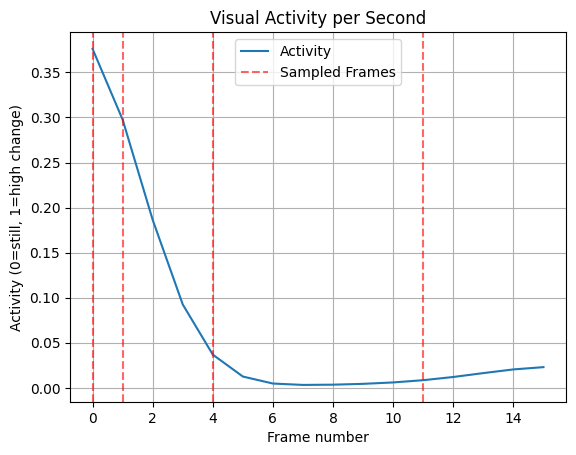

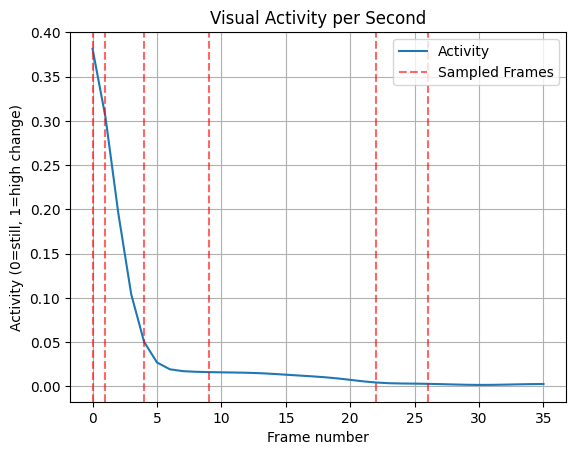

In [ ]:
for cut in os.listdir(CUTS_PATH):
    cut_folder_path = os.path.join(CUTS_DESCRIPTION_PATH, cut.split(".")[0])
    print(f"cuts folder path : {cut_folder_path}")
    # Example usage

    video_cut_path = os.path.join(CUTS_PATH, cut)
    print(cut)

    activity = get_activity_per_frame(video_cut_path)
    activity = smooth_signal_gaussian(activity)
    adaptive_samples = adaptive_frame_sampling(activity=activity)

    if os.path.isdir(cut_folder_path):
        shutil.rmtree(cut_folder_path)
        print(f"Nuked {cut_folder_path}")
    os.mkdir(os.path.join(cut_folder_path))
    plot_and_save_cut_activity(
        path=os.path.join(cut_folder_path, f"{cut}_activity_plot.png"),
        activity=activity,
        sampled_indices=adaptive_samples,
    )

    save_frames_from_video(video_cut_path, adaptive_samples, cut_folder_path)

    # break

sunlight-Scene-028
/home/tyler/python/agents/cut_descriptions/sunlight-Scene-028


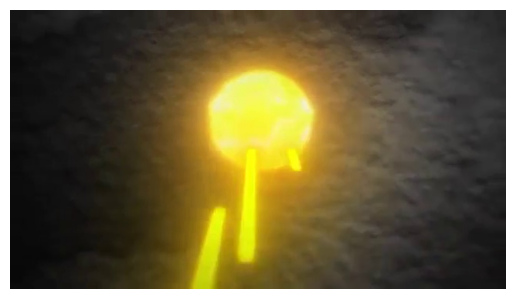

This image appears to be a screenshot from a video showing an unusual visual effect. In the center of the image is a glowing yellow traffic sign with a green arrow pointing to the right. Surrounding this central sign are two smaller signs. The larger one on the left has a black arrow that points to the right, and the one on the right is a pedestrian crossing sign. Additionally, there's a small, yellow speed limit sign in the bottom left corner. These signs are set against a dark background with some indistinct shapes or lights visible. The overall impression is of an altered image or a digital manipulation rather than a real scene from a roadway.


ZeroDivisionError: division by zero

In [ ]:
def describe_image_with_llava(image_path: str) -> str:
    """
    Sends an image to LLaVA 7B running on Ollama and returns the description.

    :param image_path: Path to the image file.
    :return: Description text returned by the model.
    """
    # Convert image to base64
    with open(image_path, "rb") as img_file:
        img_base64 = base64.b64encode(img_file.read()).decode("utf-8")

    # Prepare request payload
    payload = {
        "model": "llava:7b",
        "prompt": "Describe the main objects in this image which is a screenshot from a video briefly. The image may not be a real photo, can be a frame fo a special computer effect.",
        "images": [img_base64],
        "stream": False,  # single response instead of token stream
    }

    # Send request to Ollama API
    try:
        response = requests.post(OLLAMA_URL, json=payload)
        response.raise_for_status()  # Raise exception for HTTP errors
        result = response.json()
        return result.get("response", "").strip()
    except requests.exceptions.RequestException as e:
        return f"Request failed: {e}"


def make_summary():
    for cut_folder in os.listdir(CUTS_DESCRIPTION_PATH):
        print(cut_folder)
        cut_folder_full_path = os.path.join(CUTS_DESCRIPTION_PATH, cut_folder)
        print(cut_folder_full_path)
        for image in os.listdir(cut_folder_full_path):
            with open(os.path.join(cut_folder_full_path, image), "rb") as f:
                img = mpimg.imread(os.path.join(cut_folder_full_path, image))
                plt.imshow(img)
                plt.axis("off")

                plt.show()
                description = describe_image_with_llava(
                    os.path.join(cut_folder_full_path, image)
                )
                print(description)
                0 / 0


make_summary()